In [85]:
import numpy as np 
import pandas as pd 
import math
import random
import seaborn as sns  
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import LabelEncoder

from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


from sklearn.cluster import KMeans

**1. Load  data**

In [86]:
gender_submission = pd.read_csv('/home/slay/kaggle/Titanic: Machine Learning from Disaster/titanic/gender_submission.csv')
test = pd.read_csv('/home/slay/kaggle/Titanic: Machine Learning from Disaster/titanic/test.csv')
train = pd.read_csv('/home/slay/kaggle/Titanic: Machine Learning from Disaster/titanic/train.csv')

**2. Feature Exploration, Engineering and Cleaning**

*We create an index and remove the spaces in the data frame that we need to restore the age data of the remaining passengers. Add some new attributes such as the name length, whether the passenger had his own cabin and the deck number on which this cabin was*

In [87]:
X_train = train.reset_index()
X_test = test.reset_index()
Y = train.Survived

X_dropna = X_train.dropna()
X_test_dropna = X_test.dropna()

Dframe = [X_train, X_test]

In [88]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

index            0
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
index            0
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [89]:
for frame in Dframe:
    
    #frame['military'] = 0
    #frame['aristo'] = 0
    
    frame['Title'] = frame.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    frame['Title'] = frame['Title'].replace('Ms','Miss')
    frame['Title'] = frame['Title'].replace('Mlle','Miss')
    frame['Title'] = frame['Title'].replace('Mme','Mrs')

    frame['famous_cabin'] = frame["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    frame['Deck'] = frame['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    frame.loc[(frame['Deck'] == 'T'), 'Deck'] = 'A'
    
    frame['IsWomanOrBoy'] = ((frame.Title == 'Master') | (frame.Sex == 'female'))
    
    frame['FamilySize'] = frame['SibSp'] + frame['Parch'] + 1
    frame['IsAlone'] = 0
    frame.loc[frame['FamilySize'] == 1, 'IsAlone'] = 1
    
    frame['Embarked'] = frame['Embarked'].fillna('S')
    frame['Fare'] = frame['Fare'].fillna(frame['Fare'].median())
    
    frame['Name_length'] = frame['Name'].apply(len)
    
    #frame.loc[frame['Title'] == 'Capt', 'military'] = 1
    #frame.loc[frame['Title'] == 'Major', 'military'] = 1
    
    #frame.loc[frame['Title'] == 'Don', 'aristo'] = 1
    #frame.loc[frame['Title'] == 'Jonkheer', 'aristo'] = 1
    #frame.loc[frame['Title'] == 'Sir', 'aristo'] = 1
    #frame.loc[frame['Title'] == 'the Countess', 'aristo'] = 1

In [90]:
X_train.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,famous_cabin,Deck,IsWomanOrBoy,FamilySize,IsAlone,Name_length
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,M,False,2,0,23
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,C,True,2,0,51
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,M,True,1,1,22
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,C,True,2,0,44
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,M,False,1,1,24


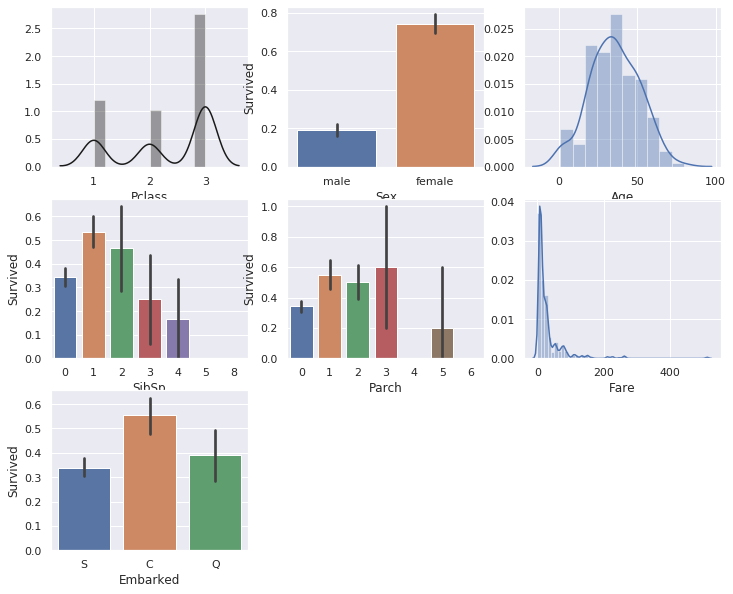

In [91]:
plt.figure(figsize=[12,10])

plt.subplot(331)
sns.distplot(X_train['Pclass'], color="k")

plt.subplot (332)                         
sns.barplot('Sex', 'Survived', data=X_train)

plt.subplot (333)
sns.distplot(X_dropna['Age']) 

plt.subplot (334)
#sns.distplot(X['SibSp'])
sns.barplot('SibSp', 'Survived', data=X_train)

plt.subplot (335)
#sns.distplot(X['Parch'])
#px.histogram(X, x="Parch").show()
sns.barplot('Parch', 'Survived', data=X_train)

plt.subplot (336)
sns.distplot(X_train['Fare'])
#train['Fare'].hist()

plt.subplot (337)
sns.barplot('Embarked', 'Survived', data=X_train)

**3. Recover Missed Values**

*Initially, we divide the sample into 4 subsamples of surviving men and women and non-survivors. Next, we find the mean and standard deviations for each subsample, we need them to find the confidence interval for the location of the mean from the population. The derf function finds a confidence interval.*

In [92]:
X_dropna_categor = pd.get_dummies(X_dropna) 
Xtest_dropna_categor = pd.get_dummies(X_test_dropna) 

# Surviving girls:
Sex_female_Survived = X_dropna_categor.loc[(X_dropna_categor.Sex_female == 1) & (X_dropna_categor.Survived == 1)]
# Dead girls:
Sex_female_NoSurvived = X_dropna_categor.loc[(X_dropna_categor.Sex_female == 1) & (X_dropna_categor.Survived == 0)]
# Surviving guys:
X_Sex_male_Survived = X_dropna_categor.loc[(X_dropna_categor.Sex_male == 1) & (X_dropna_categor.Survived == 1)] 
# Dead guys:
X_Sex_male_NoSurvived = X_dropna_categor.loc[(X_dropna_categor.Sex_male == 1) & (X_dropna_categor.Survived == 0)]

X_test_male = Xtest_dropna_categor.loc[Xtest_dropna_categor.Sex_male == 1]
X_test_female = Xtest_dropna_categor.loc[Xtest_dropna_categor.Sex_female == 1]

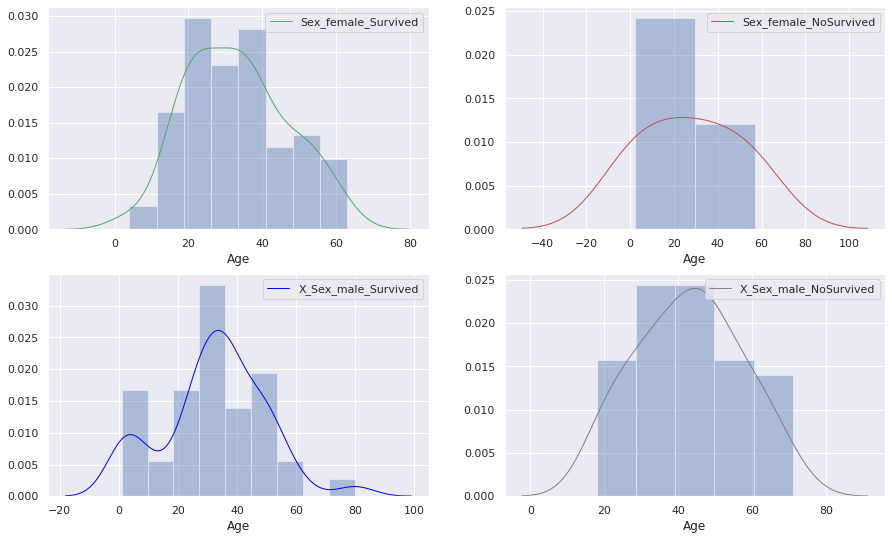

In [93]:
# age distribution of survivors and non-survivors:
sns.set(rc={'figure.figsize': (15, 9)})
plt.subplot (221)
sns.distplot(Sex_female_Survived['Age'] , kde_kws = {'color': 'g', 'lw':1, 'label': 'Sex_female_Survived' })
plt.subplot (222)
sns.distplot(Sex_female_NoSurvived['Age'] , kde_kws = {'color': 'r', 'lw':1, 'label': 'Sex_female_NoSurvived' })
plt.subplot (223)
sns.distplot(X_Sex_male_Survived['Age'] , kde_kws = {'color': 'blue', 'lw':1, 'label': 'X_Sex_male_Survived' })
plt.subplot (224)
sns.distplot(X_Sex_male_NoSurvived['Age'] , kde_kws = {'color': 'gray', 'lw':1, 'label': 'X_Sex_male_NoSurvived' })

In [94]:
female_Survived_mean, female_NoSurvived_mean = Sex_female_Survived['Age'].mean(), Sex_female_NoSurvived['Age'].mean()
male_Survived_mean, male_NoSurvived_mean = X_Sex_male_Survived['Age'].mean(), X_Sex_male_NoSurvived['Age'].mean()

female_Survived_std, female_NoSurvived_std = Sex_female_Survived['Age'].std(), Sex_female_NoSurvived['Age'].std()
male_Survived_std, male_NoSurvived_std = X_Sex_male_Survived['Age'].std(), X_Sex_male_NoSurvived['Age'].std()

female_std, female_mean = X_test_female['Age'].std(), X_test_female['Age'].mean()
male_std, male_mean = X_test_male['Age'].std(), X_test_male['Age'].mean()

In [95]:
# Confidence interval calculation function: 
def derf(sample, mean, std):
    age_shape = sample['Age'].shape[0] # sample size
    standard_error_ofthe_mean = std / math.sqrt(age_shape)
    random_mean = random.uniform(mean-(1.96*standard_error_ofthe_mean), mean+(1.96*standard_error_ofthe_mean))
    return round(random_mean, 2)    

In [96]:
for i in X_train.loc[(X_train['Sex']=='female') & (X_train['Survived']==1) & (X_train['Age'].isnull())].index:
    X_train.at[i, 'Age'] = derf(Sex_female_Survived, female_Survived_mean, female_Survived_std)

for h in X_train.loc[(X_train['Sex']=='female') & (X_train['Survived']==0) & (X_train['Age'].isnull())].index:
    X_train.at[h, 'Age'] = derf(Sex_female_NoSurvived, female_NoSurvived_mean, female_NoSurvived_std)
    
for l in X_train.loc[(X_train['Sex']=='male') & (X_train['Survived']==1) & (X_train['Age'].isnull())].index:
    X_train.at[l, 'Age'] = derf(X_Sex_male_Survived, male_Survived_mean, male_Survived_std)
    
for b in X_train.loc[(X_train['Sex']=='male') & (X_train['Survived']==0) & (X_train['Age'].isnull())].index:
    X_train.at[b, 'Age'] = derf(X_Sex_male_NoSurvived, male_NoSurvived_mean, male_NoSurvived_std)
    
for p in X_test.loc[(X_test['Sex']=='male') & (X_test['Age'].isnull())].index:
    X_test.at[p, 'Age'] = derf(X_test_male, male_mean, male_std)

for y in X_test.loc[(X_test['Sex']=='female') & (X_test['Age'].isnull())].index:
    X_test.at[y, 'Age'] = derf(X_test_female, female_mean, female_std)


In [97]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

index             0
PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          0
Title             0
famous_cabin      0
Deck              0
IsWomanOrBoy      0
FamilySize        0
IsAlone           0
Name_length       0
dtype: int64
index             0
PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           327
Embarked          0
Title             0
famous_cabin      0
Deck              0
IsWomanOrBoy      0
FamilySize        0
IsAlone           0
Name_length       0
dtype: int64


In [98]:
X_train = X_train.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'index'], axis=1) 
X_test = X_test.drop(['Name', 'Ticket', 'Cabin', 'index'], axis=1)

**4. Translation of categorical features**

In [99]:
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns_train = []
features = X_train.columns.values.tolist()
for col in features:
    if X_train[col].dtype in numerics: continue
    categorical_columns_train.append(col)
categorical_columns_train

['Sex', 'Embarked', 'Title', 'Deck', 'IsWomanOrBoy']

In [16]:
# Encoding categorical features
for col in categorical_columns_train:
    if col in X_train.columns:
        le = LabelEncoder()
        le.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        X_train[col] = le.transform(list(X_train[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))   

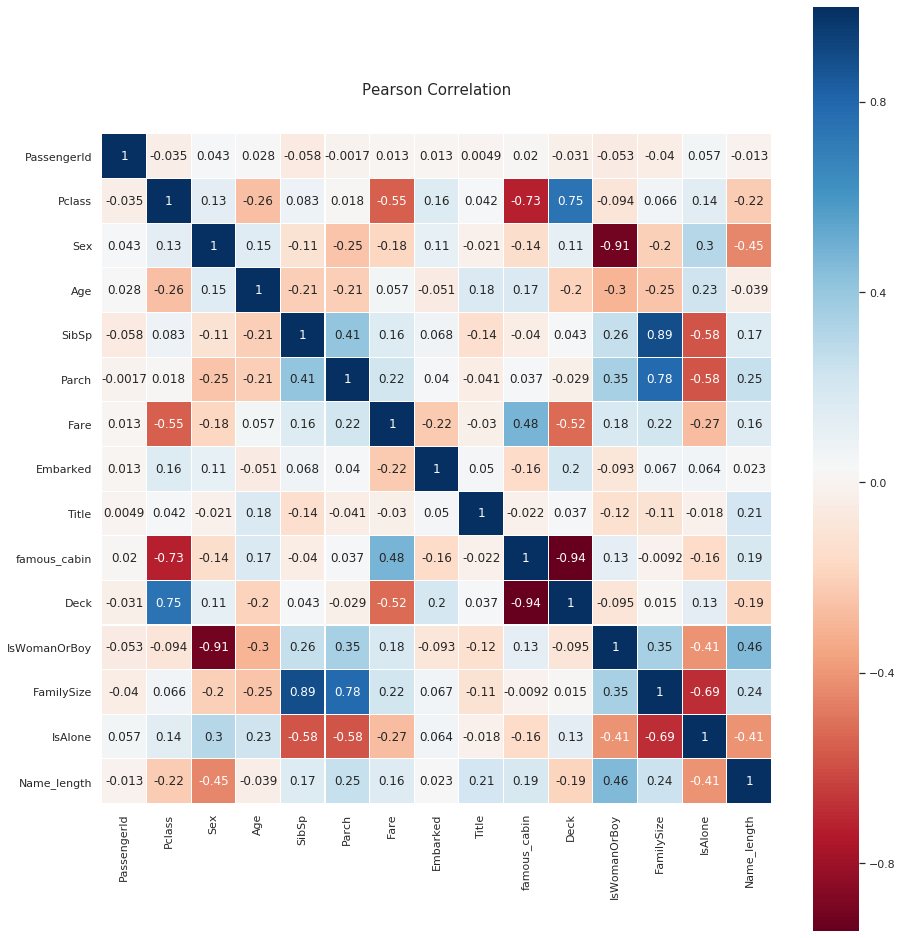

In [20]:
cor_map = plt.cm.RdBu
plt.figure(figsize=(15,17))
plt.title('Pearson Correlation', y=1.05, size=15)
sns.heatmap(X_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=cor_map, linecolor='white', annot=True)  

**5. We divide the data into different training sets**

In [64]:
X_train_rf_1, X_train_rf_2, y_train_rf_1, y_train_rf_2 = train_test_split(
    X_train, Y, test_size=0.33, random_state=42)

print(X_train_rf_1.shape)
print(X_train_rf_2.shape)

(596, 15)
(295, 15)


**7. Classification**

*We define two forests and train them using the selection of parameters on the data that we received in the process of separation. The resulting probability of survival is divided into two groups.*

In [65]:
rf = RandomForestClassifier()
best_rf = {}

In [66]:
random_grid = {'criterion': ['gini', 'entropy'],
               'bootstrap': [True, False],
               'max_depth': [3, 5, 7, 9, 11, 13, 16, 19, 20],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [5, 10, 15, 20, 25],
               'min_samples_split': [40, 50, 60, 62, 64, 66, 68],
               'n_estimators': [300, 600, 900, 1200, 1500, 1800]}

In [67]:
rf_search_one = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100)
rf_search_two = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200)

In [68]:
#rf_search_one.fit(X_train, Y)
rf_search_one.fit(X_train_rf_1, y_train_rf_1)
best_rf_s1 = rf_search_one.best_estimator_
#best_rf_s1.fit(X_train, Y)
best_rf_s1.fit(X_train_rf_1, y_train_rf_1)
y_predicted_prob_1 = best_rf_s1.predict_proba(X_test)  
print(best_rf_s1.classes_)
y_predicted_prob_1 = list(y_predicted_prob_1)
best_rf['rf_ndom'] = y_predicted_prob_1
print('finish')

/home/slay/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



[0 1]
finish


In [69]:
rf_search_two.fit(X_train_rf_2, y_train_rf_2)
best_rf_s2 = rf_search_two.best_estimator_
best_rf_s2.fit(X_train_rf_2, y_train_rf_2)
y_predicted_prob_2 = best_rf_s2.predict_proba(X_test) 
print(best_rf_s1.classes_)
y_predicted_prob_2 = list(y_predicted_prob_2)
best_rf['rf_ndom2'] = y_predicted_prob_2
print('finish')

/home/slay/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



[0 1]
finish


In [70]:
print(rf_search_one.best_params_)
print(rf_search_two.best_params_)

{'n_estimators': 900, 'min_samples_split': 40, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 19, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 300, 'min_samples_split': 40, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}


In [71]:
survivor_probability_dictionary = {}
Dictionary_Probability_Dead = {}
for ary in best_rf:
    survivor_probability = []
    Nosurvivor_probability = []
    for i in best_rf[ary]:
        survivor_probability.append(i[1])
        Nosurvivor_probability.append(i[0])
    survivor_probability_dictionary[ary] = survivor_probability
    Dictionary_Probability_Dead[ary] = Nosurvivor_probability

In [72]:
temp_y = pd.DataFrame.from_dict({
    'PassengerId': list(test.PassengerId), 
    'rf_1_survivor': survivor_probability_dictionary['rf_ndom'],
    'rf_2_survivor': survivor_probability_dictionary['rf_ndom2'],
    'rf_1_Nosurvivor': Dictionary_Probability_Dead['rf_ndom'],
    'rf_2_Nosurvivor': Dictionary_Probability_Dead['rf_ndom2'] })

In [73]:
temp_y.head()

,PassengerId,rf_1_survivor,rf_2_survivor,rf_1_Nosurvivor,rf_2_Nosurvivor
0,892,0.191386,0.090749,0.808614,0.909251
1,893,0.457473,0.537605,0.542527,0.462395
2,894,0.085226,0.089303,0.914774,0.910697
3,895,0.082295,0.123256,0.917705,0.876744
4,896,0.587662,0.659128,0.412338,0.340872


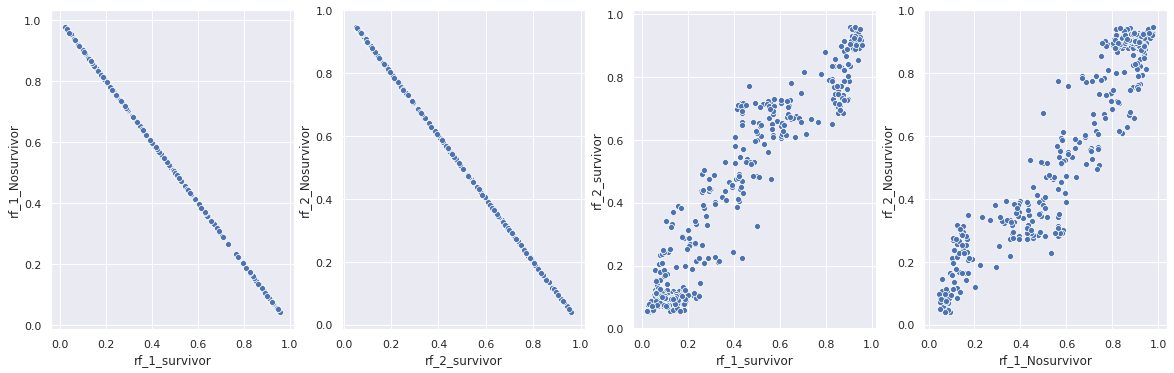

In [74]:
plt.figure(figsize=[20,20])

plt.subplot(341)
ax = sns.scatterplot(x="rf_1_survivor", y="rf_1_Nosurvivor", data=temp_y)
plt.subplot(342)
ax = sns.scatterplot(x="rf_2_survivor", y="rf_2_Nosurvivor", data=temp_y)

plt.subplot(343)
ax = sns.scatterplot(x="rf_1_survivor", y="rf_2_survivor", data=temp_y)
plt.subplot(344)
ax = sns.scatterplot(x="rf_1_Nosurvivor", y="rf_2_Nosurvivor", data=temp_y)

In [75]:
ftest = ['rf_1_survivor', 'rf_2_survivor']

In [76]:
n_clusters = 2
km = KMeans(n_clusters=n_clusters)
data = temp_y[[ftest[0], ftest[1]]]
temp_y['claster_rf1_surv'] = km.fit_predict(data)

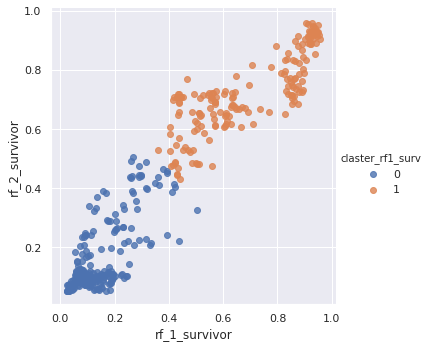

In [77]:
ax = sns.lmplot(x='rf_1_survivor', y='rf_2_survivor', data = temp_y, hue='claster_rf1_surv', fit_reg=False)

In [84]:
#cluster_r = temp_y['claster_rf1_surv'].replace({0:1, 1:0})
#temp_y['claster_rf1_reversurv'] = cluster_r

In [78]:
#ax = sns.lmplot(x='rf_1_survivor', y='rf_2_survivor', data = temp_y, hue='claster_rf1_reversurv', fit_reg=False)

In [80]:
finall_F = pd.DataFrame.from_dict({'PassengerId': list(temp_y.PassengerId), 
                                   'Survived': list(temp_y.claster_rf1_surv)})

In [81]:
finall_F.head(6)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0


In [82]:
finall_F.to_csv("Submission_test0.csv", index=False)